In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monodepthloss
DEVICE = torch.device("cuda:0")
# Moving to the gpu: net = Net().to(DEVICE)

In [2]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        encode = []
        relu = nn.ReLU(True)
        pool = nn.MaxPool2d(2)
        encode.append(nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), relu, pool))
        encode.append(nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), relu, pool))
        encode.append(nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), relu, pool))
        encode.append(nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), relu, pool))
        encode.append(nn.Sequential(nn.Conv2d(256, 256, 3, padding=1), relu))
        
        self.encoders = []
        self.encoders.append(nn.Sequential(*encode).to(DEVICE)) # for n
        self.encoders.append(nn.Sequential(*encode).to(DEVICE)) # for n-1 & n+1
        #self.encoders.append(nn.Sequential(*encode).to(DEVICE)) # for D(n-1) & D(n+1)
        
        decode = []
        decode.append(nn.Sequential(nn.Conv2d(256*3, 256, 3, padding = 1), relu))
        decode.append(nn.Sequential(nn.ConvTranspose2d(256*4, 128, 3, stride=2, \
                                                       padding=1, output_padding=1), relu))
        decode.append(nn.Sequential(nn.ConvTranspose2d(128*4, 64, 3, stride=2, \
                                                       padding=1, output_padding=1), relu))
        decode.append(nn.Sequential(nn.ConvTranspose2d(64*4, 32, 3, stride=2, \
                                                       padding=1, output_padding=1), relu))
        decode.append(nn.Sequential(nn.ConvTranspose2d(32*4, 1, 3, stride=2, \
                                                       padding=1, output_padding=1), relu))
        self.decoder = nn.Sequential(*decode).to(DEVICE)
        todepth = []
        todepth.append(nn.Sequential(nn.Conv2d(128, 1, 3, padding = 1), relu).to(DEVICE))
        todepth.append(nn.Sequential(nn.Conv2d(64, 1, 3, padding = 1), relu).to(DEVICE))
        todepth.append(nn.Sequential(nn.Conv2d(32, 1, 3, padding = 1), relu).to(DEVICE))
        self.todepth = todepth # Layers to convert intermediate results into maps


        '''
        transform = []
        transform.append(nn.Sequential(nn.Conv3d(1, 32, 3), relu))
        transform.append(nn.Sequential(nn.Conv2d(32, 1, 3), relu))
        
        self.transformer = nn.Sequential(*transform)
        '''    
    def forward(self, x1, x2, x3):
        xout = []
        inputs = [x1,x2,x3]
        skips = [[],[],[]]
        for i in range(3):
            x = inputs[i]
            for layer in self.encoders[i-1]: #Encoder 2 used for n-1 and n+1 (x1,x3)
                x = layer(x)
                skips[i].append(x)
        x = skips[-1][-1]
        for i, layer in enumerate(self.decoder):
            for j, encoder in enumerate(skips):
                if j == len(skips)-1 and i == 0: break
                x = torch.cat((x,encoder[-(i+1)]),1)
            x = layer(x)
            if(i > 0):
                if(i == 4):
                    xout.append(x)
                else:
                    xout.append(self.todepth[i-1](x))
        skips = []
        return xout

network = autoencoder()
network = network.to(DEVICE)
x = torch.randn(3,1280,720).to(DEVICE)
xout = network(x.view(-1,1,1280,720),x.view(-1,1,1280,720),x.view(-1,1,1280,720))
for tensor in xout:
    print(tensor.size())

torch.Size([3, 1, 160, 90])
torch.Size([3, 1, 320, 180])
torch.Size([3, 1, 640, 360])
torch.Size([3, 1, 1280, 720])


  0%|          | 0/147312 [00:00<?, ?it/s]

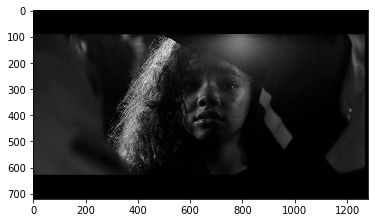

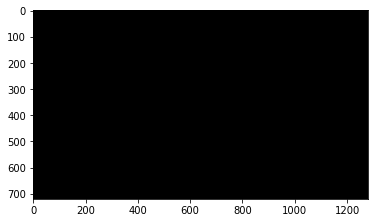

  0%|          | 0/147312 [00:00<?, ?it/s]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [15]:
import os
images = os.listdir('left/skyscraper')
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.optim as optim
from tqdm import tqdm
import random

'''
#SOURCE: MONODEPTH 1    
def apply_disparity(img, disp):
    batch_size, _, height, width = img.size()

    # Original coordinates of pixels
    x_base = torch.linspace(0, 1, width).repeat(batch_size,
                height, 1).type_as(img)
    y_base = torch.linspace(0, 1, height).repeat(batch_size,
                width, 1).transpose(1, 2).type_as(img)

    # Apply shift in X direction
    x_shifts = disp[:, 0, :, :]  # Disparity is passed in NCHW format with 1 channel
    flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)
    # In grid_sample coordinates are assumed to be between -1 and 1
    output = F.grid_sample(img, 2*flow_field - 1, mode='bilinear',
                           padding_mode='zeros')

    return output'''



optimizer = optim.Adam(network.parameters(),lr=0.001) # .parameters() takes the parts 
    # that can be optimized, ie
    # they have not been pretrained and frozen.
    # lr or learning rate might decay over time in more complicated situations, .001 is common e-3
    # We wont be decaying it here however!
frames = list(range(len(images)))
frames = frames[1200:-10900] # Remove meaningless title images.
EPOCHS = 1
i = 0
#results = []
network.load_state_dict(torch.load('model.t'))
for epoch in range(EPOCHS):
    random.shuffle(frames)
    for frame in tqdm(frames):
        imageLN = cv2.imread('left/skyscraper/'+images[frame-1], cv2.IMREAD_GRAYSCALE)
        imageLNp = cv2.imread('left/skyscraper/'+images[frame], cv2.IMREAD_GRAYSCALE)
        imageLNm = cv2.imread('left/skyscraper/'+images[frame-2], cv2.IMREAD_GRAYSCALE)
        LinN = torch.as_tensor(imageLN,dtype=float).view(-1,1,1280,720).to(DEVICE)
        LinNp = torch.as_tensor(imageLNp,dtype=float).view(-1,1,1280,720).to(DEVICE)
        LinNm = torch.as_tensor(imageLNm,dtype=float).view(-1,1,1280,720).to(DEVICE)
        LinN = torch.div(LinN, 255)
        LinNm = torch.div(LinNm, 255)
        LinNp = torch.div(LinNp, 255)
        
        imageR = cv2.imread('right/skyscraper/'+images[frame-1][0:-4]+'_R.jpg', cv2.IMREAD_GRAYSCALE)
        Rout = torch.as_tensor(imageR,dtype=float).view(-1,1,1280,720).to(DEVICE)
        Rout = torch.div(Rout, 255)
        
        network.zero_grad()
        output = network(LinNm.type(torch.cuda.FloatTensor), \
                         LinN.type(torch.cuda.FloatTensor), \
                         LinNp.type(torch.cuda.FloatTensor))
        #reconstructed = apply_disparity(LinN.type(torch.cuda.FloatTensor), output)
        plt.imshow(Rout.cpu().view(720, 1280), 'gray')
        plt.show()
        plt.imshow(output[-1].view(720, 1280).cpu().detach().numpy(), 'gray')
        plt.show()
        print(sum(output[-3].view(720//4, 1280//4).cpu()))
        break
        """
        Args:
            input [disp1, disp2, disp3, disp4]
            target [left, right]
        Return:
            (float): The loss
        """
        loss_function = monodepthloss.MonodepthLoss(
                n=4,
                SSIM_w=0.85,
                disp_gradient_w=0.1, lr_w=1).to(DEVICE)
        
        loss = loss_function(output,[LinN.type(torch.cuda.FloatTensor),\
                                     Rout.type(torch.cuda.FloatTensor)])
        loss.backward()
        if (i%100 == 0):
            results.append(loss.item())
        i +=1
        if (i%10000 == 0):
            torch.save(network.state_dict(), 'model2.t')
        optimizer.step()

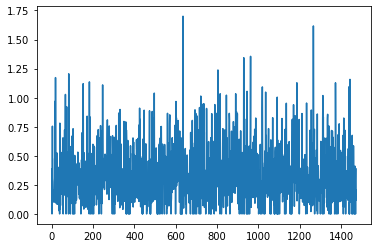

In [4]:
plt.plot(results)

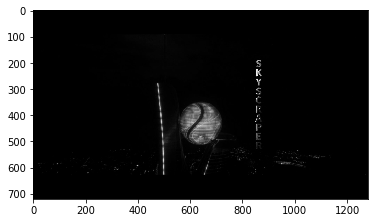

In [42]:
test = cv2.imread('left/skyscraper/'+images[-10900], cv2.IMREAD_GRAYSCALE)
plt.imshow(test, 'gray')
plt.show()
# use images 0 - 1200 to - 10900